In [ ]:
import os
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import keras.utils as image
from keras.applications import MobileNetV3Large
from keras.models import Model
from keras.layers import GlobalAveragePooling2D

2024-03-26 13:54:38.677081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 13:54:38.720333: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 13:54:38.720375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 13:54:38.721641: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 13:54:38.728963: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Define directories
train_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/train'
test_dir = 'C:/Users/dhruv/Desktop/project/CyberVision-Advanced-Visual-Malware-Classification-main/malimg_dataset/test'

# Image size
image_size = (224, 224, 3)

In [3]:

# Load images
def load_images(directory):
    images = []
    labels = []
    for label, class_name in enumerate(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                img_path = os.path.join(class_dir, filename)
                img = image.load_img(img_path, target_size=image_size)
                img_array = image.img_to_array(img)
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)


In [4]:
# Load training and test images
train_images, train_labels = load_images(train_dir)
test_images, test_labels = load_images(test_dir)

# Preprocess images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [5]:
# Load MobileNetV3 (large) with pre-trained weights on ImageNet
base_mobilenetv3_large = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='None')

# Add Global Average Pooling (GAP) layer
x = base_mobilenetv3_large.output
x = GlobalAveragePooling2D()(x)

# Create the model
mobilenetv3_large_with_gap = Model(inputs=base_mobilenetv3_large.input, outputs=x)


2024-03-26 13:55:03.003886: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 915 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:88:00.0, compute capability: 8.0
2024-03-26 13:55:03.008313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7803 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:89:00.0, compute capability: 8.0
2024-03-26 13:55:03.011632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38374 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:b1:00.0, compute capability: 8.0
2024-03-26 13:55:03.014563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 37955 MB memory:  -> device: 3, name: NVIDIA A100-PCIE-40GB, pci bus i

In [6]:
# Extract features using MobileNetV1
def extract_features(model, images, batch_size):
    num_images = images.shape[0]
    features = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx]
        batch_features = model.predict(batch)
        features.append(batch_features)
    return np.concatenate(features)

In [7]:

batch_size = 8
# Extract features using MobileNetV3 (large)
train_features = extract_features(mobilenetv3_large_with_gap, train_images, batch_size)
test_features = extract_features(mobilenetv3_large_with_gap, test_images, batch_size)

2024-03-26 13:55:06.205203: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-26 13:55:06.314251: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1/1 [==============================] - 2s 2s/step


2024-03-26 13:55:07.097328: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-03-26 13:55:07.142406: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


1/1 [==============================] - 0s 196ms/step


In [8]:
# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10]
}

# Create Random Forest classifier
rf_classifier = RandomForestClassifier()

# Use GridSearchCV to find the best parameters for Random Forest
rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(train_features, train_labels)

# Get the best parameters for Random Forest
best_rf_params = rf_grid_search.best_params_

# Train the final Random Forest model with the best parameters
final_rf_classifier = RandomForestClassifier(**best_rf_params)
start_time_rf = time.time()
final_rf_classifier.fit(train_features, train_labels)
train_time_rf = time.time() - start_time_rf

# Predict labels for the test set using Random Forest
rf_predictions = final_rf_classifier.predict(test_features)

# Evaluate accuracy for Random Forest
rf_accuracy = accuracy_score(test_labels, rf_predictions)
print("\nBest Random Forest Parameters:", best_rf_params)
print("Random Forest Accuracy:", rf_accuracy)



Best Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 400}
Random Forest Accuracy: 0.9832810867293625


In [9]:
# Additional evaluation metrics for Random Forest
precision_rf = precision_score(test_labels, rf_predictions, average='weighted')
recall_rf = recall_score(test_labels, rf_predictions, average='weighted')
f1_rf = f1_score(test_labels, rf_predictions, average='weighted')

print("Train Time (sec) Random Forest:", train_time_rf)
grid_train_time_rf = rf_grid_search.cv_results_['mean_fit_time'][rf_grid_search.best_index_]
print("Train Time (sec) Grid Random Forest:", grid_train_time_rf)

# Calculate Matthews Correlation Coefficient (MCC) for Random Forest
mcc_rf = matthews_corrcoef(test_labels, rf_predictions)
print("Matthews Correlation Coefficient (MCC) Random Forest:", mcc_rf)


Train Time (sec) Random Forest: 47.33601117134094
Train Time (sec) Grid Random Forest: 40.63553396860758
Matthews Correlation Coefficient (MCC) Random Forest: 0.9805706691113507


In [10]:

# Confusion matrix for Random Forest
conf_matrix_rf = confusion_matrix(test_labels, rf_predictions)
precision_rf = precision_score(test_labels, rf_predictions, average='weighted')

FP_rf = conf_matrix_rf.sum(axis=0) - np.diag(conf_matrix_rf)
FN_rf = conf_matrix_rf.sum(axis=1) - np.diag(conf_matrix_rf)
TP_rf = np.diag(conf_matrix_rf)
TN_rf = conf_matrix_rf.sum()


In [11]:
# Display results for Random Forest
print("\nResults for Random Forest:")
print("Precision (Random Forest):", precision_rf)
print("Recall (Random Forest):", recall_rf)
print("F1 Score (Random Forest):", f1_rf)
print("True Positive Rate (TPR) (Random Forest):", np.mean(TP_rf / (TP_rf + FN_rf)))
print("True Negative Rate (TNR) (Random Forest):", np.mean(TN_rf / (TN_rf + FP_rf)))
print("False Positive Rate (FPR) (Random Forest):", np.mean(FP_rf / (FP_rf + TN_rf)))
print("False Negative Rate (FNR) (Random Forest):", np.mean(FN_rf / (TP_rf + FN_rf)))
print("False Discovery Rate (FDR) (Random Forest):", np.mean(FP_rf / (FP_rf + TP_rf)))
print("False Omission Rate (FOR) (Random Forest):", np.mean(FN_rf / (FN_rf + TN_rf)))
print("Matthews Correlation Coefficient (MCC) (Random Forest):", mcc_rf)



Results for Random Forest:
Precision (Random Forest): 0.9824743005799538
Recall (Random Forest): 0.9832810867293625
F1 Score (Random Forest): 0.9819191666716635
True Positive Rate (TPR) (Random Forest): 0.9588392238392238
True Negative Rate (TNR) (Random Forest): 0.9993348864754941
False Positive Rate (FPR) (Random Forest): 0.0006651135245059331
False Negative Rate (FNR) (Random Forest): 0.04116077616077615
False Discovery Rate (FDR) (Random Forest): 0.042626102536588474
False Omission Rate (FOR) (Random Forest): 0.0006636510084584052
Matthews Correlation Coefficient (MCC) (Random Forest): 0.9805706691113507


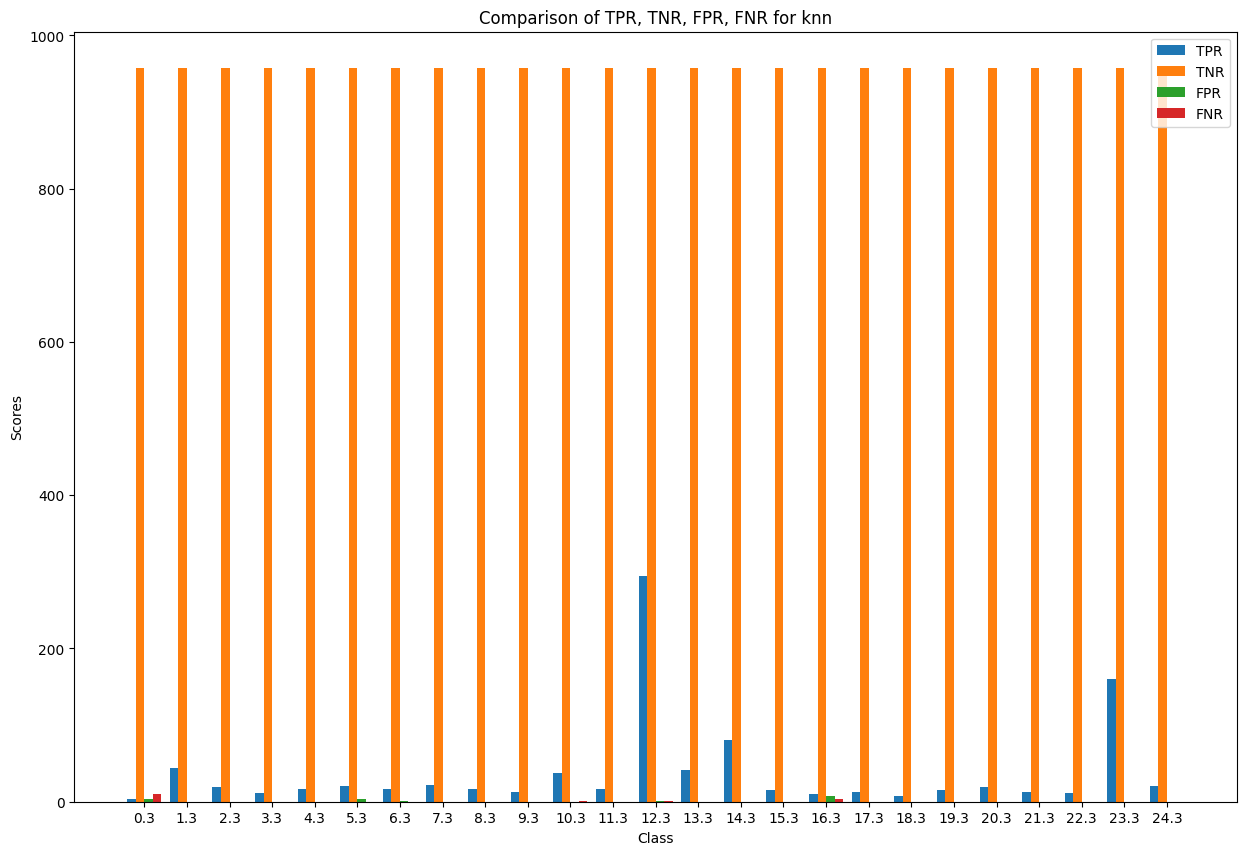

In [12]:
# Plot TPR, TNR, FPR, FNR
fig, ax = plt.subplots(figsize=(15, 10))

bar_width = 0.2
index = np.arange(25)  # Assuming you have 25 classes, adjust this based on your data

bar1 = ax.bar(index, TP_rf, bar_width, label='TPR')
bar2 = ax.bar(index + bar_width, TN_rf, bar_width, label='TNR')
bar3 = ax.bar(index + 2 * bar_width, FP_rf, bar_width, label='FPR')
bar4 = ax.bar(index + 3 * bar_width, FN_rf, bar_width, label='FNR')

ax.set_xlabel('Class')
ax.set_ylabel('Scores')
ax.set_title('Comparison of TPR, TNR, FPR, FNR for knn')
ax.set_xticks(index + 1.5 * bar_width)
ax.legend()

plt.show()

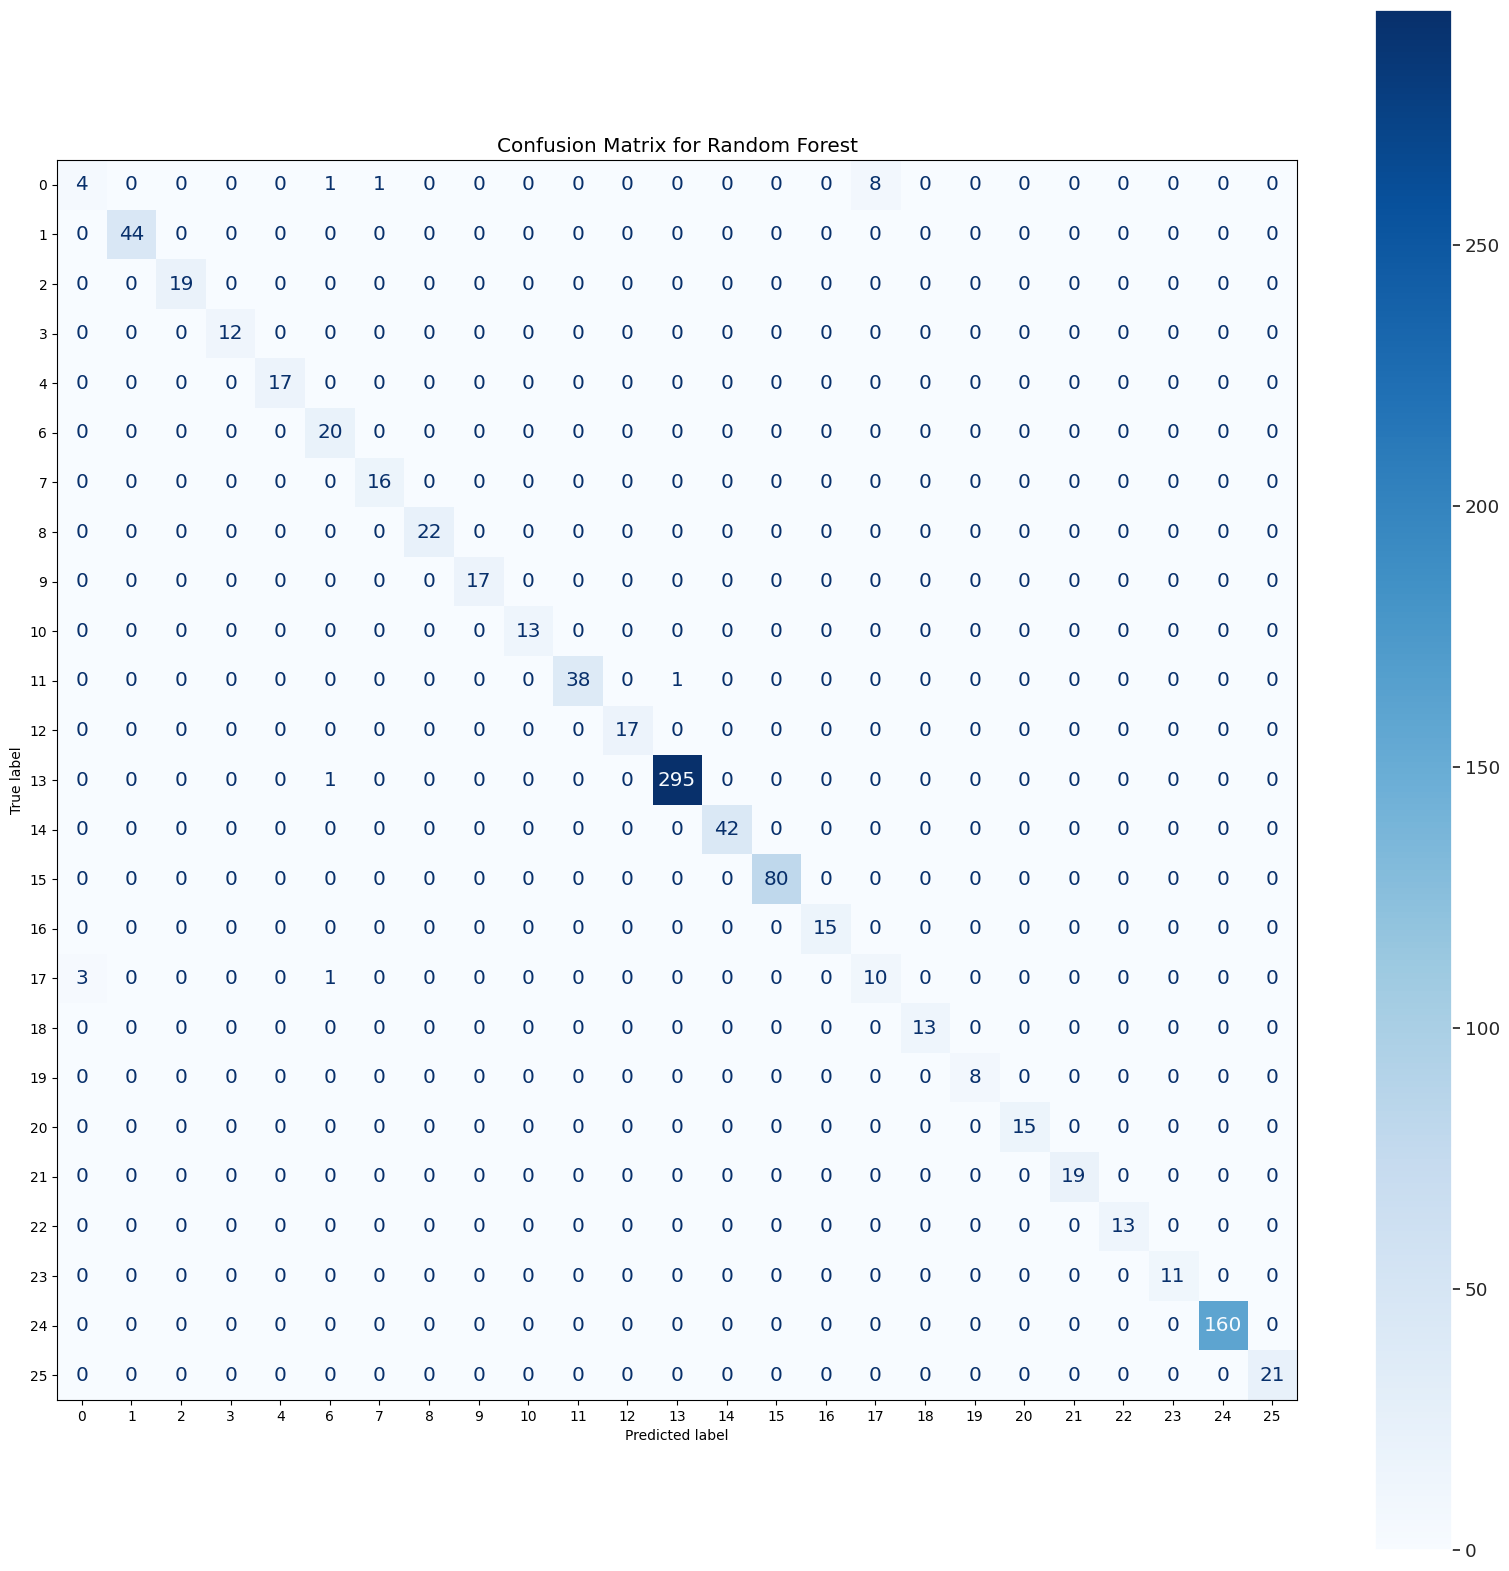

: 

In [13]:
# Plot Confusion Matrix for Random Forest
fig, ax = plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.2)  # Adjust font size for better readability
disp = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=np.unique(test_labels))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix for Random Forest')
plt.show()